In [1]:
import cv2
import mediapipe as mp
import numpy as np
import os
from matplotlib import pyplot as plt
import time

# Using mediapipe holistic, full body pose estimation

In [2]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks,  mp_holistic.FACEMESH_CONTOURS)
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

In [5]:
def draw_custom_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks,  mp_holistic.FACEMESH_CONTOURS,
                             mp_drawing.DrawingSpec(color=(255, 255, 204), thickness=1, circle_radius=1),
                             mp_drawing.DrawingSpec(color=(225, 225, 225), thickness=1, circle_radius=1))
    
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(255, 0, 255), thickness=2, circle_radius=2),
                             mp_drawing.DrawingSpec(color=(204, 153, 255), thickness=2, circle_radius=2))
    
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2, circle_radius=2),
                             mp_drawing.DrawingSpec(color=(255, 255, 0), thickness=2, circle_radius=2))
    
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(0, 128, 0), thickness=2, circle_radius=2),
                             mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2))
    

# Get landmarks keypoints from frames

In [6]:
def get_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)

    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
  
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3) 

    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    
    return np.concatenate([pose, face, lh, rh])

# Load data

In [7]:
DATA_PATH = os.path.join('points_Data')

actions = np.array(['hello', 'thank you', 'i am', 'w', 'a'])
#['##', hello', 'thank you', 'i love you', 'i am', 'w', 'a', 'i', 'l']
no_sequences = 30

sequence_length = 30

In [8]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [9]:
label_map = {label:num for num, label in enumerate(actions)}

In [19]:
actions

array(['hello', 'thank you', 'i am', 'w', 'a'], dtype='<U9')

In [ ]:
sequences, labels = [], []

for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in  range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [ ]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [ ]:
sequences.shape

# Tensor Flow Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import load_model

In [ ]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [ ]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, activation='relu', input_shape=(30, 1662)))
model.add(LSTM(256, return_sequences=True, activation='relu'))
model.add(LSTM(128, return_sequences=False, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            442112    
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 5)                 165       
                                                                 
Total params: 596741 (2.28 MB)
Trainable params: 596741 

In [21]:
res = model.predict(X_train)
len(res)

4/4 [==============================] - 0s 22ms/step


120

In [22]:
actions[np.argmax(res[1])]

'thank you'

In [23]:
actions[np.argmax(y_test[1])]

'w'

In [24]:
#model.save('sign.keras')

In [25]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, confusion_matrix

In [26]:
yhat = model.predict(X_train)

4/4 [==============================] - 0s 23ms/step


In [27]:
ytrue = np.argmax(y_train, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [28]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[97,  0],
        [ 0, 23]],

       [[95,  0],
        [ 0, 25]],

       [[95,  0],
        [ 0, 25]],

       [[98,  0],
        [ 0, 22]],

       [[95,  0],
        [ 0, 25]]], dtype=int64)

In [29]:
accuracy_score(ytrue, yhat)

1.0

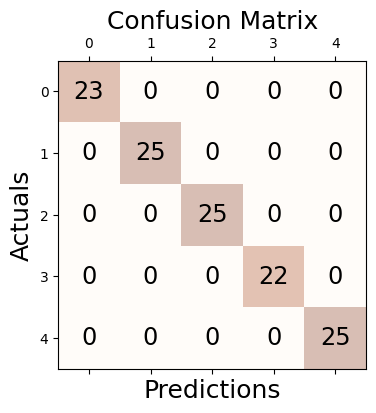

In [30]:
matrix = confusion_matrix(y_true=ytrue, y_pred=yhat)
fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        ax.text(x=j, y=i,s=matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [31]:
colors = [(245,117,16), (117,245,16), (16,117,245),(16,117,22),(21,23,245),(16,22,33)]
#, (16,117,245),(21,23,245),(16,22,33),(16,117,22),(16,0,245),(23,117,245)
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [32]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

NameError: name 'image' is not defined

<Figure size 1800x1800 with 0 Axes>

# Test the model

In [13]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from tensorflow.keras.models import load_model
model=load_model('sign.keras')
model.summary()

ValueError: Layer 'lstm_cell' expected 3 variables, but received 0 variables during loading. Expected: ['lstm_1/lstm_cell/kernel:0', 'lstm_1/lstm_cell/recurrent_kernel:0', 'lstm_1/lstm_cell/bias:0']

In [35]:
sequence = []
sentence = []
threshold = 0.8


cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic:
    
    prev_keypoints = None  # Store the previous keypoints
    
    while cap.isOpened():
        
        ret, frame = cap.read()
        
        image, results = mediapipe_detection(frame, holistic)
         
        draw_custom_landmarks(image, results)
        
        # Predict only when there's a significant change in keypoints
        keypoints = get_keypoints(results)
        
        if prev_keypoints is not None:
            # Calculate the Euclidean distance between the current and previous keypoints
            euclidean_distance = np.linalg.norm(np.array(prev_keypoints) - np.array(keypoints))
            #print(euclidean_distance)
            # You can set a threshold for the distance below which you don't make predictions
            if euclidean_distance > 0.2:
                sequence.append(keypoints)
                sequence = sequence[-30:]
        
        prev_keypoints = keypoints
        
        
        #predict
        
#         keypoints = get_keypoints(results)
#         sequence.append(keypoints)
#         sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
        if res.any():
            if res[np.argmax(res)].any() > threshold:
                if len(sentence) > 0:
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                        
                else:
                    sentence.append(actions[np.argmax(res)])
                  

    
        if len(sentence) > 5:
            sentence = sentence[-5:]
        # Viz probabilities
        
        #image = prob_viz(res, actions, image, colors)
            
        
        cv2.rectangle(image, (0, 0), (640, 40), (243, 1, 150), -1)
        cv2.putText(image, ' '.join(sentence), (3, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        cv2.imshow("Camera", image)
        
        if cv2.waitKey(10) & 0XFF == ord('q'):
            break
        
cap.release()
cv2.destroyAllWindows()
    

In [175]:
cap.release()
cv2.destroyAllWindows()

In [ ]:
sequence = []
sentence = []
threshold = 0.9


cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic:
    
    prev_keypoints = None  # Store the previous keypoints
    
    while cap.isOpened():
        
        ret, frame = cap.read()
        
        image, results = mediapipe_detection(frame, holistic)
         
        draw_custom_landmarks(image, results)
        
        # Predict only when there's a significant change in keypoints
        keypoints = get_keypoints(results)
        
        if prev_keypoints is not None:
            # Calculate the Euclidean distance between the current and previous keypoints
            euclidean_distance = np.linalg.norm(np.array(prev_keypoints) - np.array(keypoints))
            #print(euclidean_distance)
            # You can set a threshold for the distance below which you don't make predictions
            if euclidean_distance > 0.6:
                sequence.append(keypoints)
                sequence = sequence[-30:]
        
        prev_keypoints = keypoints
        
        
        #predict
        
        keypoints = get_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
        if res.any():
            if res[np.argmax(res)].any() > threshold:
                if len(sentence) > 0:
                    if actions[np.argmax(res)] != '_':
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                        
                else:
                    sentence.append(actions[np.argmax(res)])
                  

    
        if len(sentence) > 5:
            sentence = sentence[-5:]
        # Viz probabilities
        
        #image = prob_viz(res, actions, image, colors)
            
        
        cv2.rectangle(image, (0, 640), (640, 600), (243, 1, 150), -1)
        cv2.putText(image, ' '.join(sentence), (3, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        cv2.imshow("Camera", image)
        
        if cv2.waitKey(10) & 0XFF == ord('q'):
            break
        
cap.release()
cv2.destroyAllWindows()
    

1/1 [==============================] - 0s 19ms/step


In [157]:
res = model.predict(X_train)
len(res)

3/3 [==============================] - 0s 33ms/step


72